In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
TWEETS_812A_JAN = "data/tweets/812A_2019_JAN_2KM.csv"
TWEETS_812A_FEV = "data/tweets/812A_2019_FEV_2KM.csv"
TWEETS_812A_MAR = "data/tweets/812A_2019_MAR_2KM.csv"
TWEETS_833A = "data/tweets/833A_2019_2KM.csv"

RAIN_GAUGE_CODES = ["355030812A", "355030833A"]

RAIN_GAUGES_JAN = "data/rain_gauges/data1.csv"
RAIN_GAUGES_FEV = "data/rain_gauges/data2.csv"
RAIN_GAUGES_MAR = "data/rain_gauges/data3.csv"

FLOODS_812A = "data/floods/812A_alags.csv"
FLOODS_833A = "data/floods/833A_alags.csv"

KEYWORDS = ["chuva", "chove", "chuvoso", "chuvosa", "chuvarada", 
            "alagamento", "alagou", "inundação", "inundada", "enxurrada",
            "rio transbordou", "córrego transbordou", "rio saiu da calha", 
            "córrego saiu da calha", "deslizamento", "escorregamento", "queda de barreira"]

## Time range creation

In [3]:
DAYS_RANGE = datetime(2019, 4, 1) - datetime(2019, 1, 1) 
TIME_PERIOD = DAYS_RANGE.days * 24 * 6

begin_date = datetime.strptime("01-01-2019", "%d-%m-%Y")

date_range = pd.date_range(begin_date, periods=TIME_PERIOD, freq="10min")
date_range = date_range.to_frame(index=False, name="time")

## Rain Gauge Data

In [4]:
def merge_rain_gauge(time_series, rain_gauge, col_name):
    time_series = pd.merge(time_series, rain_gauge, left_on="time", right_on="datahora", how="left")
    time_series = time_series.drop(columns=["codEstacao", "datahora"])
    time_series = time_series.rename(columns={"valorMedida": col_name})
    time_series[col_name] = time_series[col_name].fillna(0)
    return time_series

rain_gauges_files = [RAIN_GAUGES_JAN, RAIN_GAUGES_FEV, RAIN_GAUGES_MAR]
rain_gauges = pd.concat(
    [pd.read_csv(file, sep=";", index_col=False, decimal=".") for file in rain_gauges_files]
)

# Filtragem dos dados
filtered_rain_gauges = rain_gauges[rain_gauges["codEstacao"].isin(RAIN_GAUGE_CODES)]
filtered_rain_gauges["datahora"] = pd.to_datetime(filtered_rain_gauges["datahora"])
filtered_rain_gauges["valorMedida"] = (
    filtered_rain_gauges["valorMedida"].str.replace(",", ".").astype(float)
)
filtered_rain_gauges = filtered_rain_gauges[["codEstacao", "datahora", "valorMedida"]]

# Separação dos dados por estação
rain_gauge_812A = filtered_rain_gauges.query("codEstacao == '355030812A'")
rain_gauge_833A = filtered_rain_gauges.query("codEstacao == '355030833A'")

# Merge dos dados na série temporal
time_series = merge_rain_gauge(date_range, rain_gauge_812A, "812A")
time_series = merge_rain_gauge(time_series, rain_gauge_833A, "833A")

C:\Users\Jefferson\AppData\Local\Temp\ipykernel_6332\2796794800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rain_gauges["datahora"] = pd.to_datetime(filtered_rain_gauges["datahora"])
C:\Users\Jefferson\AppData\Local\Temp\ipykernel_6332\2796794800.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rain_gauges["valorMedida"] = (


In [5]:
time_series.head()

,time,812A,833A
0,2019-01-01 00:00:00,0.0,0.0
1,2019-01-01 00:10:00,0.0,0.0
2,2019-01-01 00:20:00,0.0,0.0
3,2019-01-01 00:30:00,0.0,0.0
4,2019-01-01 00:40:00,0.0,0.0


## Tweet data

In [6]:
def load_tweets(files, rain_gauge_label):
    tweets = pd.concat([pd.read_csv(file) for file in files])
    tweets = tweets[["date", "text"]]
    tweets["rain_gauge"] = rain_gauge_label
    return tweets

tweets_812 = load_tweets([TWEETS_812A_JAN, TWEETS_812A_FEV, TWEETS_812A_MAR], "812A_tweets")
tweets_833 = load_tweets([TWEETS_833A], "833A_tweets")

tweets = pd.concat([tweets_812, tweets_833])

# Filtragem dos tweets com palavras-chave
pattern = "|".join(KEYWORDS)
filtered_data = tweets[tweets["text"].str.contains(pattern, case=False, na=False)]
filtered_data["date"] = pd.to_datetime(filtered_data["date"]).dt.round("10min")

# Contagem de tweets por data e estação
tweet_counts = filtered_data.groupby(["date", "rain_gauge"]).size().reset_index(name="count")
result = tweet_counts.pivot(index="date", columns="rain_gauge", values="count").fillna(0).reset_index()

# Merge dos dados na série temporal
total_data = pd.merge(time_series, result, left_on="time", right_on="date", how="left")
total_data[["812A_tweets", "833A_tweets"]] = total_data[["812A_tweets", "833A_tweets"]].fillna(0)

total_data = total_data.drop(columns="date")

# Conversão da data de UTC para GMT-3
total_data["time"] = total_data["time"].dt.tz_localize("UTC").dt.tz_convert("America/Sao_Paulo")

C:\Users\Jefferson\AppData\Local\Temp\ipykernel_6332\2995276161.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["date"] = pd.to_datetime(filtered_data["date"]).dt.round("10min")


## Floods

In [9]:
def load_floods(file, rain_gauge_label):
    floods = pd.read_csv(file)
    floods["DATA"] = pd.to_datetime(floods["DATA"])
    floods = floods[floods["DATA"] <= "2019-03-31"]
    floods = floods[["DATA", "H_INICIO", "H_FIM"]]
    floods["rain_gauge"] = rain_gauge_label
    return floods

floods_812A = load_floods(FLOODS_812A, "812A")
floods_833A = load_floods(FLOODS_833A, "833A")

floods = pd.concat([floods_812A, floods_833A])
floods["date_start"] = pd.to_datetime(floods["DATA"].astype(str) + ' ' + floods["H_INICIO"].astype(str))
floods["date_end"] = pd.to_datetime(floods["DATA"].astype(str) + ' ' + floods["H_FIM"].astype(str))
floods = floods[["date_start", "date_end", "rain_gauge"]]

# Ajuste de datas e fusos horários
floods[["date_start", "date_end"]] = floods[["date_start", "date_end"]].apply(lambda x: x.dt.round("10min").dt.tz_localize("America/Sao_Paulo"))

# Adicionando colunas de inundações ao total_data
for gauge in floods["rain_gauge"].unique():
    total_data[f"{gauge}_flood"] = 0

# Atualizando total_data com inundações
for _, row in floods.iterrows():
    mask = (total_data["time"] >= row["date_start"]) & (total_data["time"] <= row["date_end"])
    total_data.loc[mask, f"{row['rain_gauge']}_flood"] = 1

# Tratamento dos dados

In [12]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype                            
---  ------       --------------  -----                            
 0   time         12960 non-null  datetime64[ns, America/Sao_Paulo]
 1   812A         12960 non-null  float64                          
 2   833A         12960 non-null  float64                          
 3   812A_tweets  12960 non-null  float64                          
 4   833A_tweets  12960 non-null  float64                          
 5   812A_flood   12960 non-null  int64                            
 6   833A_flood   12960 non-null  int64                            
dtypes: datetime64[ns, America/Sao_Paulo](1), float64(4), int64(2)
memory usage: 708.9 KB


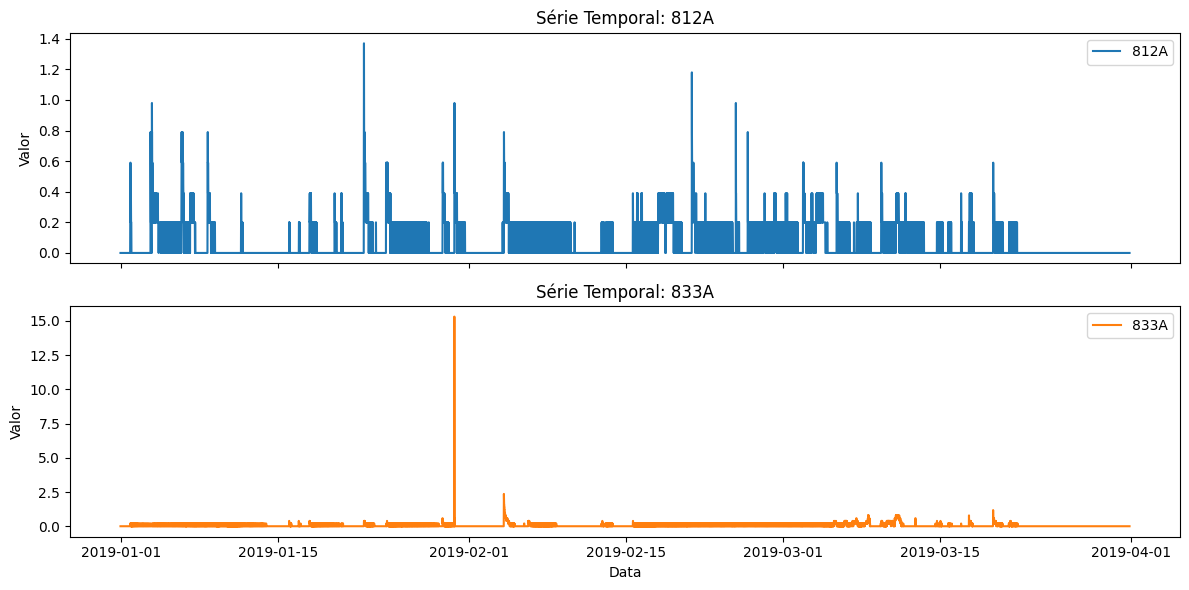

In [11]:
def plot_rain_gauge(df):
    _, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    columns = ["812A", "833A"]

    for i, col in enumerate(columns):
        axs[i].plot(df["time"], df[col], label=col, color=f"C{i}")
        axs[i].set_title(f"Série Temporal: {col}")
        axs[i].set_ylabel("Valor")
        axs[i].legend()

    axs[-1].set_xlabel("Data")

    plt.tight_layout()
    plt.show()

df = total_data
plot_rain_gauge(df)

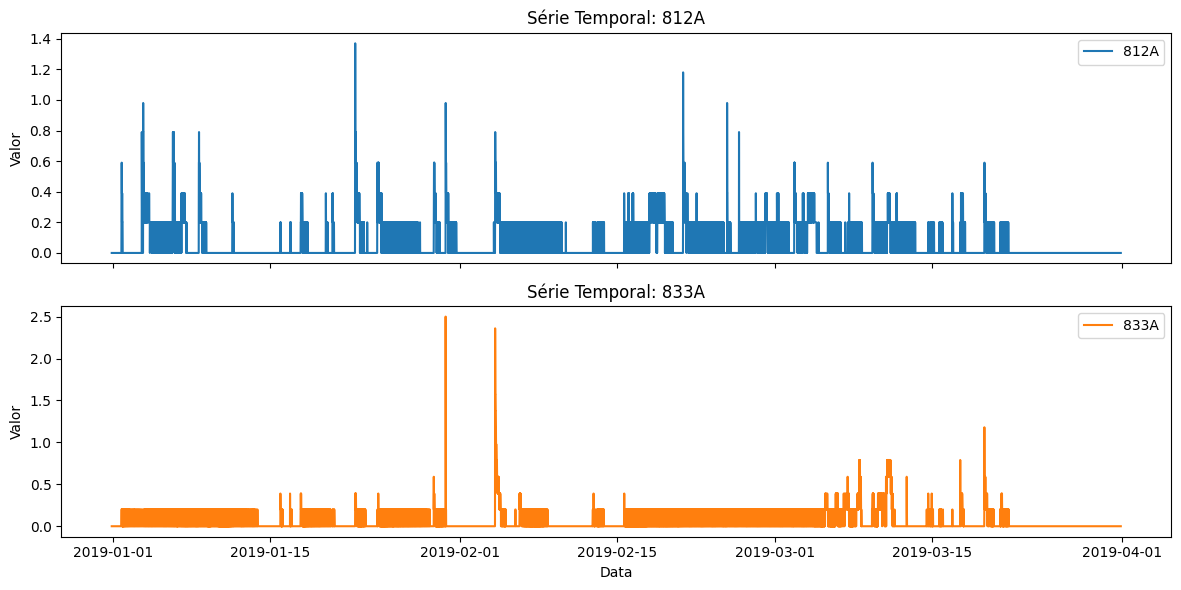

In [13]:
df['833A'] = df['833A'].apply(lambda x: 2.5 if x > 2.5 else x)

plot_rain_gauge(df)

In [ ]:
df["flood"] = 0
df.loc[((df["812A_flood"] == 1) | (df["833A_flood"] == 1)), "flood"] = 1

df["tweets"] = df["833A_tweets"] + df["812A_tweets"]
df["tweets"] = df["tweets"].astype(int)

df.to_csv("data/results/time_data.csv", sep=";", index=False)